In [1]:
# Most basic stuff for EDA.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Core packages for text processing.
import string
import re

# Libraries for text preprocessing.
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Loading some sklearn packaces for modelling.
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation, NMF # not actively using
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Utility
import logging
import itertools

In [4]:
# Core packages for general use throughout the notebook.
import random
import warnings
import time
import datetime

# For customizing our plots.
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

In [5]:
# for build our model
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

# Setting some options for general use.
import os
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('updated_dataset.csv')
df.head()

,Unnamed: 0,Review,neg,neu,pos,compound,Labels
0,0,"Contrary to other reviews, I have zero complai...",0.059,0.852,0.089,0.6059,4
1,1,Last summer I had an appointment to get new ti...,0.145,0.761,0.094,-0.4339,1
2,2,"Friendly staff, same starbucks fair you get an...",0.000,0.703,0.297,0.6705,4
3,3,The food is good. Unfortunately the service is...,0.179,0.725,0.096,-0.5046,1
4,4,Even when we didn't have a car Filene's Baseme...,0.017,0.812,0.171,0.9633,5


In [7]:
#map target label to string

In [8]:
decode_map = {1: "ANGRY", 2: "NEGATIVE", 3: "NEUTRAL", 4: "POSITIVE", 5: "GREAT"}
def decode_sentiment(Labels):
    return decode_map[int(Labels)]

In [9]:
%%time
df.Labels = df.Labels.apply(lambda x: decode_sentiment(x))

Wall time: 48.2 ms


# cleaning Text

In [10]:
def remove_stopwords(text):
    tokens = []
    for token in text.split():
        if token not in stop:
            tokens.append(token)
    return " ".join(tokens)


def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions
df['text_clean'] = df['Review'].apply(lambda x: remove_stopwords(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_URL(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punct(x))


In [11]:
df.head()


,Unnamed: 0,Review,neg,neu,pos,compound,Labels,text_clean
0,0,"Contrary to other reviews, I have zero complai...",0.059,0.852,0.089,0.6059,POSITIVE,Contrary reviews I zero complaints service pri...
1,1,Last summer I had an appointment to get new ti...,0.145,0.761,0.094,-0.4339,ANGRY,Last summer I appointment get new tires wait s...
2,2,"Friendly staff, same starbucks fair you get an...",0.000,0.703,0.297,0.6705,POSITIVE,Friendly staff starbucks fair get anywhere els...
3,3,The food is good. Unfortunately the service is...,0.179,0.725,0.096,-0.5046,ANGRY,The food good Unfortunately service hit miss T...
4,4,Even when we didn't have a car Filene's Baseme...,0.017,0.812,0.171,0.9633,GREAT,Even car Filenes Basement worth bus trip Water...


In [12]:
df['Character Count'] = df['text_clean'].apply(lambda x: len(str(x)))

def plot_dist3(df_x, feature, title):
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax1.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax1, color='#e74c3c')
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

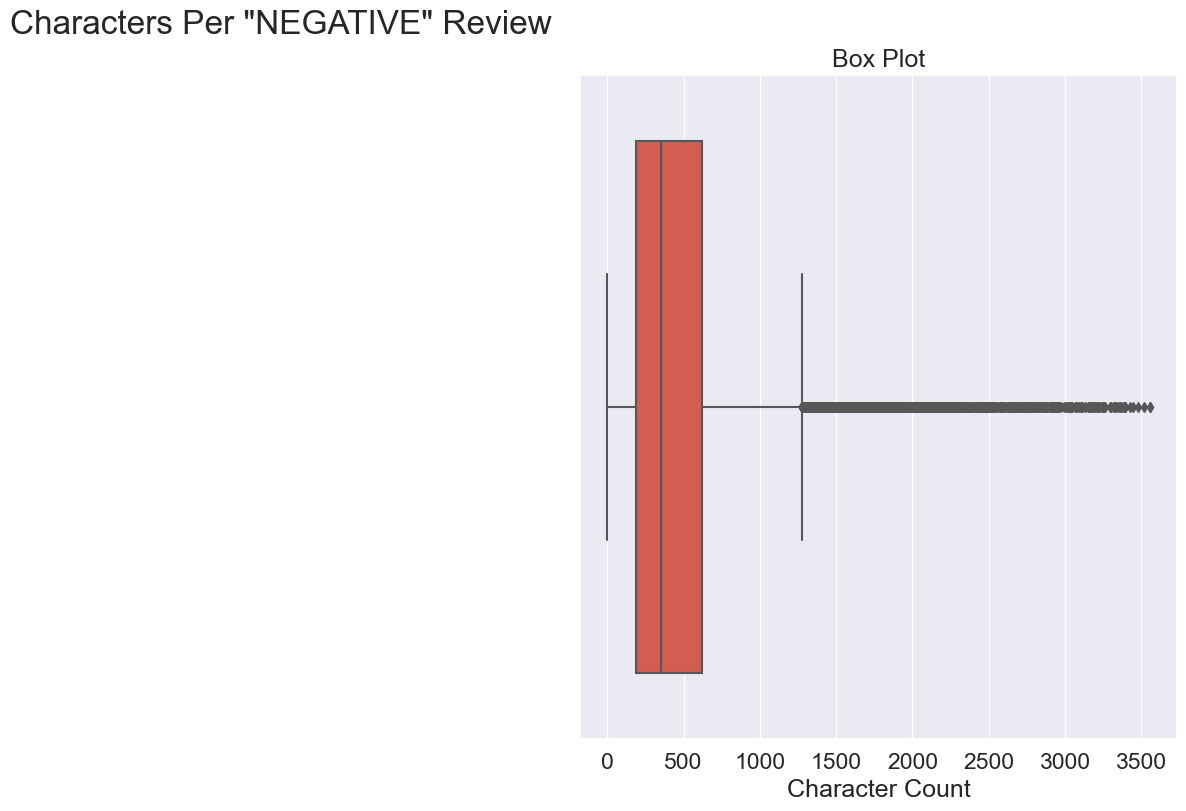

In [13]:
plot_dist3(df[df['Labels'] == 'NEGATIVE'], 'Character Count',
           'Characters Per "NEGATIVE" Review')

# Setup environment to build model

In [14]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

In [15]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [16]:
# hyperparameters
max_length = 128
batch_size = 64


In [17]:
# Bert Tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# splitting the data

In [18]:
train_df, test = train_test_split(df, test_size=0.01, random_state=42) 
x_train, dev = train_test_split(train_df, test_size=0.01, random_state=42)

In [19]:
train = x_train[:1500]

In [20]:
labels = train.Labels.unique().tolist()
labels

['GREAT', 'POSITIVE', 'ANGRY', 'NEUTRAL', 'NEGATIVE']

In [21]:
encoder = LabelEncoder()
encoder.fit(train.Labels.tolist())

y_train = encoder.transform(train.Labels.tolist())
y_test = encoder.transform(test.Labels.tolist())
y_dev = encoder.transform(dev.Labels.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_dev = y_dev.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1500, 1)
y_test (380, 1)


In [22]:
#takes a list of strings as input and tokenizes into sequence of integer ID
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=max_length, padding='max_length', truncation=True) 
    
    return tf.constant(tokens['input_ids'])

In [23]:
train_encoded = bert_encode(train.text_clean)
dev_encoded = bert_encode(dev.text_clean)


train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded, y_train))
    .shuffle(128)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded, y_dev))
    .shuffle(128)
    .batch(batch_size)
)

# MODEL

In [1]:
def bert_model():

    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
    last_hidden_states = bert_encoder(input_word_ids)[0]   
    x = tf.keras.layers.SpatialDropout1D(0.2)(last_hidden_states)
    x = tf.keras.layers.Conv1D(64, 3, activation='relu')(x)
    x = tf.keras.layers.Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    

    
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)
    model = tf.keras.Model(input_word_ids, outputs)
   
    return model

In [2]:
with strategy.scope():
    model = bert_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=adam_optimizer,metrics=['accuracy'])

    model.summary()

NameError: name 'strategy' is not defined

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-5, patience=5)]  
#early stopping to stop the training process once the validation loss starts to increase, 
#indicating that the model is starting to overfit.

In [27]:
# Start train
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=3,
    validation_data=dev_dataset,
    verbose=1,
    callbacks = callbacks)


Epoch 1/3
24/24 [==============================] - 2149s 87s/step - loss: 1.3762 - accuracy: 0.5160 - val_loss: 1.2613 - val_accuracy: 0.5491 - lr: 1.0000e-05
Epoch 2/3
24/24 [==============================] - 2126s 88s/step - loss: 1.2683 - accuracy: 0.5567 - val_loss: 1.2048 - val_accuracy: 0.5491 - lr: 1.0000e-05
Epoch 3/3
24/24 [==============================] - 1840s 77s/step - loss: 1.2328 - accuracy: 0.5567 - val_loss: 1.1637 - val_accuracy: 0.5491 - lr: 1.0000e-05


In [134]:
model.save("my_model.h5")

In [135]:
model.save_weights(f'sentiment_weights_v1.h5')

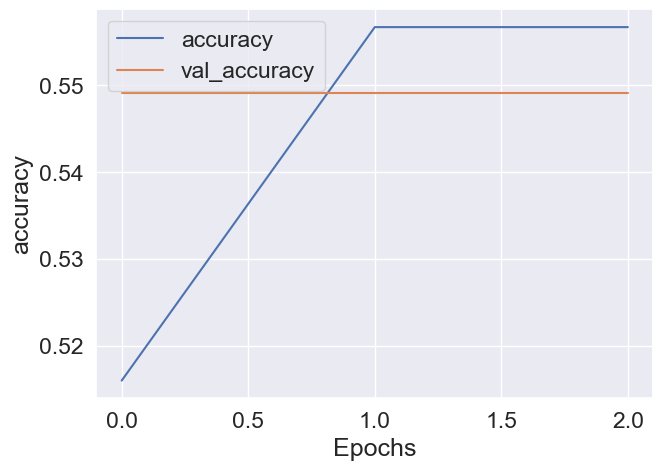

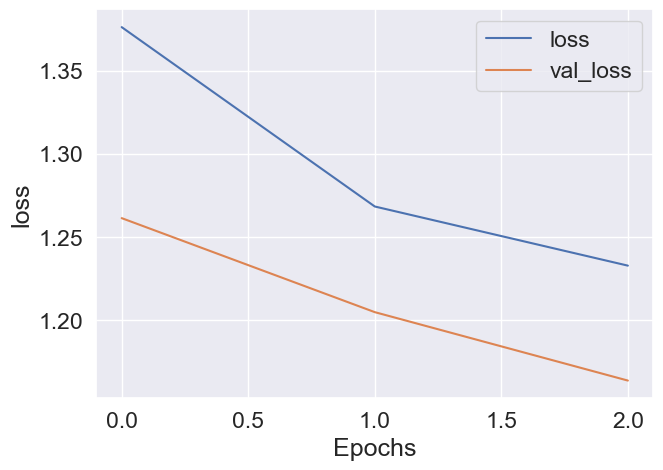

In [136]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
   
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [137]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        if score < 0.2:
            label = "ANGRY"
        elif score < 0.4:
            label = "NEGATIVE"
        elif score < 0.6:
            label = "NEUTRAL"
        elif score < 0.8:
            label = "HAPPY"
        else:
            label = "GREAT"
    else:
        if score < 0.5:
            label = "NEGATIVE"
        else:
            label = "POSITIVE"
    return label


In [138]:
class_names = ["ANGRY", "NEGATIVE", "NEUTRAL", "POSITIVE", "GREAT"]


In [139]:
import time
import numpy as np

def predict(text,include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_encoded = bert_encode([text])
    # Predict
    scores = model.predict([x_encoded])[0]
    class_idx = np.argmax(scores)
    label = class_names[class_idx]
    score = scores[class_idx]
    label = decode_sentiment(score, include_neutral=True)
    # Decode sentiment
    return {"label": label, "score": float(score),
            "elapsed_time": time.time()-start_at}

In [140]:
predict("I hate the economy")

1/1 [==============================] - 3s 3s/step


{'label': 'NEGATIVE',
 'score': 0.3468444347381592,
 'elapsed_time': 3.1426336765289307}

In [141]:
predict("I would prefer writing a crawler to create this dataset but i couldn't", True)

1/1 [==============================] - 3s 3s/step


{'label': 'NEUTRAL',
 'score': 0.41653674840927124,
 'elapsed_time': 3.0013809204101562}

In [143]:
predict("I wish I was dead")

1/1 [==============================] - 3s 3s/step


{'label': 'NEGATIVE',
 'score': 0.38785913586616516,
 'elapsed_time': 2.854097843170166}